In [476]:
# import required modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import box
import random
from sklearn import metrics

In [477]:
# set directory paths
root = '../../..'
gt_bbox_dir = os.path.join(root, 'data/subset_valid/gt/')
pred_bbox_dir = os.path.join(root, 'data/subset_valid/pred/')

In [478]:
# set constants
gt_format = 'xywh_norm'
pred_format = 'y1x1y2x2_norm'
iou_thres = 0.0
output_path = 'subset_validation.csv'

In [479]:
pred_bbox_fn = os.listdir(pred_bbox_dir)
gt_bbox_fn = os.listdir(gt_bbox_dir)

In [480]:
def parse_txt (label_fp, format_bbox, dataset):
    """Obtain x_min, y_min, x_max, and y_max of bounding box from txt file
    Args:
        label_fp (str): filepath to bounding box .txt file in detect.py output format
        format_bbox: 'x1y1x2y2' or 'xywh_norm' or 'x1y1x2y2_norm'
        dataset: 'predicted' or 'ground_truth'
    Returns:
        coords (numpy array)
        conf (float, returned only if dataset == 'predicted')
    """
    if format_bbox == 'y1x1y2x2_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                x_min = int(float(vals[1]) * 419)
                y_min = int(float(vals[2]) * 419)
                x_max = int(float(vals[3]) * 419)
                y_max = int(float(vals[0]) * 419)
                coords = np.array([y_min, x_min, y_max, x_max])
                if dataset == 'ground_truth':
                    return coords
                elif dataset == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf
    elif format_bbox == 'xywh_norm':
        with open(label_fp, 'r') as label:
            line = str(label.readline())
            if len(line) == 0:
                return None
            else:
                vals = line.split(' ')
                norm_x = float(vals[1])
                norm_y = float(vals[2])
                norm_w = float(vals[3])
                norm_h = float(vals[4])
                x_min = int((norm_x * 419) - ((norm_w * 419) / 2))
                y_min = int((norm_y * 419) - ((norm_h * 419) / 2))
                x_max = int((norm_x * 419) + ((norm_w * 419) / 2))
                y_max = int((norm_y * 419) + ((norm_h * 419) / 2))
                coords = np.array([x_min, y_min, x_max, y_max])
                if dataset == 'ground_truth':
                    return coords
                elif dataset == 'predicted':
                    conf = float(vals[5])
                    conf = '%.4f'%(conf)
                    return coords, conf

In [481]:
def calc_CT_IoU (bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Adapted from: https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    Args:
        bb1: [x1,y1,x2,y2]
        bb2: [x1,y1,x2,y2]    
    The (x1, y1) position is at the top left corner (or the bottom right - either way works).
    The (x2, y2) position is at the bottom right corner (or the top left).
    Returns:
        intersection_over_union, a float in [0, 1]
    """
    y_max, x_min, y_min, x_max = bb2
    bb2 = [x_min, y_min, x_max, y_max]
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
    # Determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # Compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [482]:
# create dictionaries of ground_truth bboxes,  predicted bboxes, and confidence
ground_truth_dict = {}
for fn in gt_bbox_fn:
    bbox = parse_txt(os.path.join(gt_bbox_dir, fn), gt_format, 'ground_truth')
    ground_truth_dict[fn] = bbox
predicted_dict = {}
conf_dict = {}
for fn in pred_bbox_fn:
    bbox, conf = parse_txt(os.path.join(pred_bbox_dir, fn), pred_format, 'predicted')
    predicted_dict[fn] = bbox
    conf_dict[fn] = conf

In [483]:
# build dataframe of image, ground_truth bboxes, predicted bboxes, and confidence
data = {'img_id' : gt_bbox_fn}
detect_df = pd.DataFrame(data, columns=['img_id'])
detect_df['img_id'] = detect_df['img_id'].replace('.png', '')
print('created dataframe')
detect_df['gt_bbox'] = detect_df['img_id'].map(pd.Series(ground_truth_dict))
detect_df['gt_format'] = 'left/bottom/right/top'
print('added ground truth boxes')
detect_df['pred_bbox'] = detect_df['img_id'].map(pd.Series(predicted_dict))
detect_df['pred_format'] = 'top/left/bottom/right'
print('added predicted boxes')
detect_df['confidence'] = detect_df['img_id'].map(pd.Series(conf_dict))
print('added confidence')
print(detect_df)

created dataframe
added ground truth boxes
added predicted boxes
added confidence
                      img_id               gt_bbox              gt_format  \
0                 116143.txt  [102, 105, 120, 118]  left/bottom/right/top   
1                 116334.txt  [192, 195, 208, 205]  left/bottom/right/top   
2                 116288.txt  [281, 280, 286, 287]  left/bottom/right/top   
3                 116035.txt  [144, 156, 199, 186]  left/bottom/right/top   
4                 116287.txt  [138, 183, 248, 203]  left/bottom/right/top   
5                 116986.txt  [227, 229, 235, 233]  left/bottom/right/top   
6                 116881.txt  [186, 184, 194, 196]  left/bottom/right/top   
7                 116569.txt  [284, 286, 290, 289]  left/bottom/right/top   
8                 116888.txt  [256, 209, 303, 351]  left/bottom/right/top   
9                 116085.txt  [182, 121, 224, 285]  left/bottom/right/top   
10                116456.txt  [314, 328, 371, 357]  left/bottom/right/t

In [484]:
# add ground_truth bbox size to dataframe
detect_df['gt_size'] = detect_df.apply(
    lambda row: None if row.gt_bbox is None else int((row.gt_bbox[2] - row.gt_bbox[0]) * (row.gt_bbox[3] - row.gt_bbox[1])), 
    axis=1
)
print('added size')

added size


In [485]:
# add IoU - cameratraps to dataframe
CT_iou_dict = {}
for fn in predicted_dict:
    if 'not_a_dam' not in fn:
        CT_iou = calc_CT_IoU(ground_truth_dict[fn], predicted_dict[fn])
        CT_iou_dict[fn] = CT_iou
    else:
        CT_iou_dict[fn] = None
detect_df['CT_iou'] = detect_df['img_id'].map(pd.Series(CT_iou_dict))
print('added CT_iou')

added CT_iou


In [486]:
# add result (tp, fp, fn, tn)
iou_thresholds = [0.0, 0.25, 0.50, 0.75]
for iou_thres in iou_thresholds:
    detect_df['tp'] = np.where((detect_df.CT_iou > iou_thres), 1, 0)
    detect_df['fp'] = np.where((detect_df.CT_iou <= iou_thres) | (detect_df.pred_bbox.notnull() & detect_df.gt_bbox.isnull()), 1, 0)
    detect_df['fn'] = np.where((detect_df.CT_iou <= iou_thres) | (detect_df.pred_bbox.isnull() & detect_df.gt_bbox.notnull()), 1, 0)
    detect_df['result@IoU'+str(iou_thres)] = detect_df.apply(
        lambda row: 'tp' if row.tp == 1 else 'fp+fn' if (row.fp == 1) & (row.fn == 1) else 'fp' if (row.fp == 1) else 'fn' if (row.fn == 1) else 'tn',
        axis=1
    )
    detect_df = detect_df.drop(['tp', 'fp', 'fn'], axis=1)
print('added results')

added results


In [487]:
detect_df = detect_df.set_index('img_id')
print(detect_df.sort_values(by='confidence', ascending=False))

                                      gt_bbox              gt_format  \
img_id                                                                 
116190.txt                 [93, 81, 176, 187]  left/bottom/right/top   
116841.txt               [250, 265, 310, 294]  left/bottom/right/top   
116649.txt               [179, 188, 265, 255]  left/bottom/right/top   
116784.txt                 [31, 49, 224, 207]  left/bottom/right/top   
116648.txt                   [60, 64, 81, 76]  left/bottom/right/top   
116901.txt                [160, 90, 334, 403]  left/bottom/right/top   
116694.txt                  [8, 37, 176, 148]  left/bottom/right/top   
116186.txt               [181, 192, 232, 220]  left/bottom/right/top   
11668.txt                [131, 118, 182, 194]  left/bottom/right/top   
116755.txt               [267, 293, 358, 332]  left/bottom/right/top   
116976.txt               [161, 173, 214, 201]  left/bottom/right/top   
116287.txt               [138, 183, 248, 203]  left/bottom/right

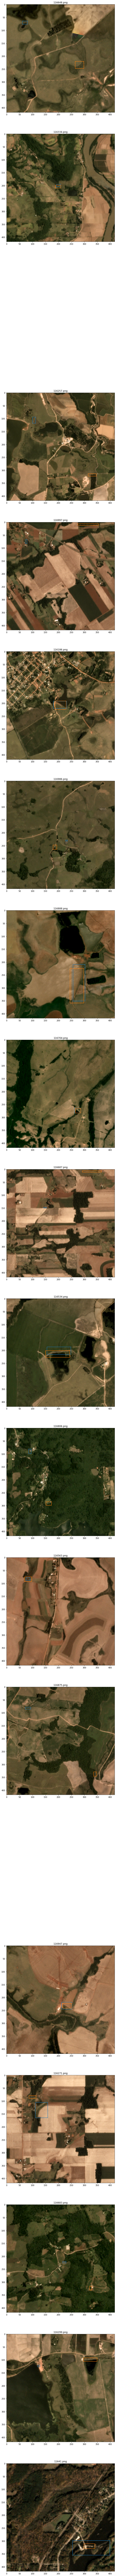

In [399]:
# visualize
fig = plt.figure(figsize=(12,240))
randlist = random.sample(range(0, 107), 20)
k = 0
images_dir = os.path.join(root, 'data/subset_valid/images/')
for i in randlist:
    img_fn = os.listdir(images_dir)[i]
    txt_fn = img_fn.replace('.png', '.txt')
    k += 1
    if 'not_a_dam' not in img_fn:
        img_fp = os.path.join(images_dir, img_fn)
        img = mpimg.imread(img_fp)
        gt_coords = ground_truth_dict[txt_fn]
        gt_bbox = box(gt_coords[0], gt_coords[1], gt_coords[2], gt_coords[3])
        x_gt,y_gt = gt_bbox.exterior.xy
        pred_coords = predicted_dict[txt_fn]
        pred_bbox = box(pred_coords[1], pred_coords[2], pred_coords[3], pred_coords[0])
        x_pr,y_pr = pred_bbox.exterior.xy
        ax = fig.add_subplot(20,1,k)
        ax.set_title(img_fn)
        ax.imshow(img)
        ax.plot(x_gt,y_gt)
        ax.plot(x_pr,y_pr)

# ground truth in blue
# predicted in orange

In [488]:
fpos_fneg = len(detect_df[detect_df['result@IoU0.0'] == 'fp+fn'])
tpos = len(detect_df[detect_df['result@IoU0.0'] == 'tp'])
fneg = len(detect_df[detect_df['result@IoU0.0'] == 'fn'])
fpos = len(detect_df[detect_df['result@IoU0.0'] == 'fp'])
tneg = len(detect_df[detect_df['result@IoU0.0'] == 'tn'])

# test
print('tp+fp_fn:', tp+fp_fn)
num_dams = 0
for fn in os.listdir(gt_bbox_dir):
    if 'not' not in fn:
        num_dams += 1
print('num_dams:', num_dams)

tp+fp_fn: 99
num_dams: 99


In [489]:
precision = (tpos) / (tpos + fpos_fneg + fpos)
print('precision:', precision)
recall = (tpos) / (tpos + fpos_fneg + fneg)
print('recall:', recall)

precision: 0.4811320754716981
recall: 0.5151515151515151


In [ ]:
precision_recall_curve